# Convert existing Tensorflow/Keras code to Ray AIR

Source: https://docs.ray.io/en/latest/ray-air/examples/convert_existing_tf_code_to_ray_air.html

## Existing Tensorflow Code

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-09-06 08:37:38.093809: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 08:37:38.118420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 08:37:38.559289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.13.0


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(len(x_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

print(f"Training Dataset: {len(x_train)} samples")
print(f"Test Dataset: {len(x_test)} samples")

Training Dataset: 60000 samples
Test Dataset: 10000 samples


2023-09-06 08:38:19.582765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 08:38:19.597540: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
def build_model() -> tf.keras.Model:
    return tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10),
        ]
    )

In [4]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

model = build_model()
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=["accuracy"],
)

In [5]:
train_history = model.fit(train_ds, epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 2s - loss: 0.2938 - accuracy: 0.9154 - 2s/epoch - 982us/step
Epoch 2/5
1875/1875 - 2s - loss: 0.1437 - accuracy: 0.9571 - 2s/epoch - 857us/step
Epoch 3/5
1875/1875 - 2s - loss: 0.1087 - accuracy: 0.9671 - 2s/epoch - 853us/step
Epoch 4/5
1875/1875 - 2s - loss: 0.0886 - accuracy: 0.9727 - 2s/epoch - 867us/step
Epoch 5/5
1875/1875 - 2s - loss: 0.0758 - accuracy: 0.9763 - 2s/epoch - 871us/step


In [6]:
# Evaluate on the test set and report metrics
eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
test_loss = eval_result["loss"]
test_accuracy = eval_result["accuracy"]
print(
    f"Final Test Loss: {test_loss:.4f}, "
    f"Final Test Accuracy: {test_accuracy:.4f}"
)

Final Test Loss: 0.0749, Final Test Accuracy: 0.9777


## Wrap everything in a training loop function

In [7]:
def get_train_test_datasets(batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(
        (x_test, y_test)).batch(batch_size)

    return train_ds, test_ds

def train_func():
    epochs = 5
    batch_size = 32

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()

    model = build_model()
    model.compile(
        optimizer=optimizer,
        loss=loss_object,
        metrics=["accuracy"],
    )
    
    train_ds, test_ds = get_train_test_datasets(batch_size)
    
    model.fit(train_ds, epochs=epochs, verbose=2)
    
    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    print(
        f"Final Test Loss: {test_loss:.4f}, "
        f"Final Test Accuracy: {test_accuracy:.4f}"
    )

## Introduce Ray AIR for Distributed Data-Parallel **Training**

In [8]:
from ray.air import session
from ray.air.integrations.keras import ReportCheckpointCallback

# 1. Pass in the hyperparameter config
def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    # 2. Synchronized model setup
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    # 3. Shard the dataset across `session.get_world_size()` workers
    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(batch_size_per_worker)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        # The number of samples is approximate, because is not always
        # a multiple of batch_size, so some batches could contain fewer than
        # `batch_size_per_worker` samples.
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )
  
    # 4. Report metrics and checkpoint the model
    report_metrics_and_checkpoint_callback = ReportCheckpointCallback(report_metrics_on="epoch_end")
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[report_metrics_and_checkpoint_callback],
        verbose=(0 if session.get_world_rank() != 0 else 2),
    )

    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    if session.get_world_rank() == 0:
        print(
            f"Final Test Loss: {test_loss:.4f}, "
            f"Final Test Accuracy: {test_accuracy:.4f}"
        )

In [9]:
def get_train_test_datasets(batch_size):
    # NEW: Now, the dataset will be downloaded to disk once per machine
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(
        (x_test, y_test)).batch(batch_size)
    return train_ds, test_ds

### Start training with TensorflowTrainer

In [10]:
from ray import air
from ray.train.tensorflow import TensorflowTrainer

num_workers = 2
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 4,
    },
    scaling_config=air.ScalingConfig(
        num_workers=num_workers,
        use_gpu=use_gpu,
    ),
)
result = trainer.fit()

2023-09-06 09:04:03,527	INFO data_parallel_trainer.py:404 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(pid=21412) 2023-09-06 09:04:04.604693: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=21412) 2023-09-06 09:04:04.630509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=21412) To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=21412) 2023-09-06 09:04:05.109655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Coul

(RayTrainWorker pid=21466) 
(RayTrainWorker pid=21466) Dataset is sharded across 2 workers:
(RayTrainWorker pid=21466) # training batches per worker = 1875 (~60000 samples)
(RayTrainWorker pid=21466) # test batches per worker = 313 (~10016 samples)


(RayTrainWorker pid=21467) 2023-09-06 09:04:08.244436: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(RayTrainWorker pid=21467) op: "TensorSliceDataset"
(RayTrainWorker pid=21467) input: "Placeholder/_0"
(RayTrainWorker pid=21467) input: "Placeholder/_1"
(RayTrainWorker pid=21467) attr {
(RayTrainWorker pid=21467)   key: "Toutput_types"
(RayTrainWorker pid=21467)   value {
(RayTrainWorker pid=21467)     list {
(RayTrainWorker pid=21467)       type: DT_DOUBLE
(RayTrainWorker pid=21467)       type: DT_UINT8
(RayTrainWorker pid=21467)     }
(RayTrainWorker pid=21467)   }
(RayTrainWorker pid=21467) }
(RayTrainWorker pid=21467) attr {
(RayTrainWorker pid=21467)   key: "_cardinality"
(RayTrainWorker pid=21467)   value {
(RayTrainWorker pid=21467)     i: 60000
(RayTrainWorker pid=2146

(RayTrainWorker pid=21466) Epoch 1/4
(RayTrainWorker pid=21466) 1875/1875 - 9s - loss: 0.2919 - accuracy: 0.9164 - 9s/epoch - 5ms/step
(RayTrainWorker pid=21466) Epoch 2/4
(RayTrainWorker pid=21466) 1875/1875 - 8s - loss: 0.1379 - accuracy: 0.9594 - 8s/epoch - 4ms/step
(RayTrainWorker pid=21466) Epoch 3/4
(RayTrainWorker pid=21466) 1875/1875 - 8s - loss: 0.1019 - accuracy: 0.9690 - 8s/epoch - 4ms/step
(RayTrainWorker pid=21466) Epoch 4/4


(RayTrainWorker pid=21466) 2023-09-06 09:04:06.565053: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=21466) 2023-09-06 09:04:06.591499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations. [repeated 2x across cluster]
(RayTrainWorker pid=21466) To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags. [repeated 2x across cluster]
(RayTrainWorker pid=21

(RayTrainWorker pid=21466) 1875/1875 - 8s - loss: 0.0834 - accuracy: 0.9740 - 8s/epoch - 4ms/step
(RayTrainWorker pid=21466) Final Test Loss: 0.0791, Final Test Accuracy: 0.9756


2023-09-06 09:04:45,187	INFO tune.py:1148 -- Total run time: 42.58 seconds (41.66 seconds for the tuning loop).


<Axes: xlabel='training_iteration'>

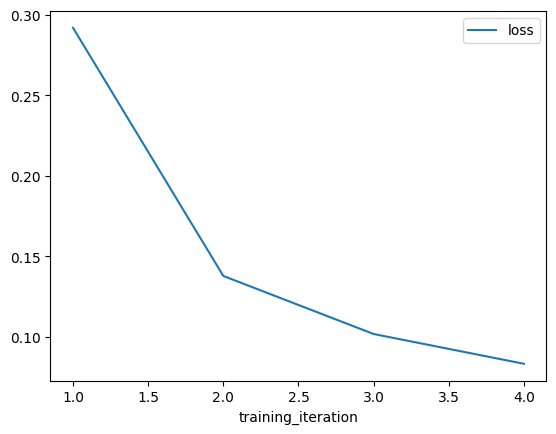

In [12]:
result.metrics_dataframe.plot("training_iteration", "loss")